## Classifying a phase transition in the XXZ model

In [1]:
import numpy as np
from qiskit import QuantumRegister, ClassicalRegister, QuantumCircuit
from qiskit import Aer, execute
import qiskit.extensions.quantum_initializer as qeqi
import time
from scipy.optimize import minimize, approx_fprime
import matplotlib.pyplot as plt
import scipy.sparse.linalg as SPLA
import csv
import pandas as pd
from functools import reduce
#from skopt import gp_minimize
from numba import jit, njit
from copy import copy, deepcopy

import sys
sys.path.append("..")

import Entangler
import TensorNetwork
import hamiltonians
#import TNOptimize
import uuid
import json
import utils

import pennylane as qml
import pennylane.numpy as np

plt.rcParams.update({'font.size': 18})
plt.rcParams.update({'figure.figsize': [9, 6]})

/tmp/ipykernel_14584/1441209272.py:10: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [2]:
cuda = False

In [3]:
n_qubits = 10
wire = list(range(n_qubits))
depth = 4
depth_classifier = 6

ent = Entangler.IsingEntangler()
TN = TensorNetwork.Checkerboard(wire, ent, depth=depth)

TN_classifier = TensorNetwork.Checkerboard(wire, ent, depth=depth_classifier)


tol = 1e-6
method = "L-BFGS-B"
n_max = 100
n_cdata = 2**n_qubits
sv_b = Aer.get_backend("statevector_simulator")
qasm_b = Aer.get_backend("qasm_simulator")
unitary_b = Aer.get_backend('unitary_simulator')

### Loading the data

The data set contains the rows where first 1024 entries are the wavefunction, next 100 are the parameters, then the Jz parameter, energy, and label

In [4]:
small_data = "vqe_2024-02-19_12-29-18.csv"
#bigger_data = "vqe_2024-02-18_18-50-31.csv"
#gpu_data = "vqe_GPU_2019-05-28_13-28-07.csv"
filename = small_data


df_vqe_2 = pd.read_csv(filename, header=None)
df_vqe_2 = df_vqe_2.map(lambda x: complex(x))

df_vqe_2[n_max] = df_vqe_2[n_max].apply(lambda x: x.real)
df_vqe_2[n_max+1] = df_vqe_2[n_max+1].apply(lambda x: x.real)
df_vqe_2[n_max+2] = df_vqe_2[n_max+2].apply(lambda x: x.real)

# df_vqe = df_vqe_2.drop([0, 1])
df_vqe = df_vqe_2

### Cleaning the data

In [5]:
df_vqe_clean = df_vqe.sort_values(by=[n_max])
df_vqe_clean.index = np.arange(len(df_vqe))
# df_vqe_clean = df_vqe.sort_index(by=[n_max])

todrop = []
tokeep = []
for i in range(len(df_vqe) // 2):
    E_1 = df_vqe_clean.iloc[i * 2, n_max + 1]
    E_2 = df_vqe_clean.iloc[i * 2 + 1, n_max + 1]
    h_1 = df_vqe_clean.iloc[i * 2, n_max]
    h_2 = df_vqe_clean.iloc[i * 2 + 1, n_max]
#     print(h_1, h_2)
#     print(E_1, E_2)
#     print("====")
    if (E_2 > E_1):
        todrop.append(i * 2 + 1)
        tokeep.append(i * 2)
    else:
        todrop.append(i * 2)
        tokeep.append(i * 2 + 1)

        
for i in range(len(df_vqe) // 2):
    E_kept = df_vqe_clean.iloc[tokeep[i], n_max + 1]
    E_dropped = df_vqe_clean.iloc[todrop[i], n_max + 1]
    if E_dropped < E_kept:
        print("AAA")

print(df_vqe_clean.iloc[:20, [n_max, n_max + 1]])

print(todrop[:10])
print(tokeep[:10])

print("=============")        
        
df_vqe_clean = df_vqe_clean.drop(todrop)
print(df_vqe_clean.iloc[:10, [n_max, n_max + 1]])

     100        101
0   0.00 -12.437708
1   0.00 -12.438302
2   0.02 -12.513859
3   0.02 -12.535575
4   0.04 -12.611746
5   0.04 -12.589815
6   0.06 -12.667098
7   0.06 -12.687944
8   0.08 -12.765143
9   0.08 -12.744831
10  0.10 -12.823273
11  0.10 -12.841849
12  0.12 -12.920228
13  0.12 -12.902485
14  0.14 -12.982204
15  0.14 -12.997663
16  0.16 -13.076787
17  0.16 -13.062887
18  0.18 -13.144181
19  0.18 -13.155852
[0, 2, 5, 6, 9, 10, 13, 14, 17, 18]
[1, 3, 4, 7, 8, 11, 12, 15, 16, 19]
     100        101
1   0.00 -12.438302
3   0.02 -12.535575
4   0.04 -12.611746
7   0.06 -12.687944
8   0.08 -12.765143
11  0.10 -12.841849
12  0.12 -12.920228
15  0.14 -12.997663
16  0.16 -13.076787
19  0.18 -13.155852


In [6]:
len(df_vqe_clean)

100

### Augmenting the data

#### Flips

First I am going to flip the spins along the X direction. Then for each of the data points I will also add a random Z rotation.

In [6]:
'''
df_flip = df_vqe_clean.copy()
# df_flip = df_vqe.copy()
df_flip.index = np.arange(len(df_flip))
'''

In [7]:
'''## hardcoded for 10 qubits and depth 4
z_gate_indices = [74 + i * 5 + k for i in range(5) for k in (4, 5)]
x_gate_indices = [74 + i * 5 + k for i in range(5) for k in (1, 2)]
'''

In [8]:
'''
for n in z_gate_indices:
    df_flip[2**n_qubits + n] *= -1

for n in x_gate_indices:
    df_flip[2**n_qubits + n] += np.pi
'''

In [9]:
'''
wavefun_cols_order = list(reversed(range(1024)))
cols_order = wavefun_cols_order + list(range(1024, n_max + 3))
df_flip = df_flip.reindex(columns=cols_order)
'''

To check the correctness of the flip operation, I will now check that the wavefunction, ansatz parameters and the energy are consistent

In [10]:
'''
h_0 = hamiltonians.xxz_heisenberg_model(10, 1, 0)
h_1 = hamiltonians.xxz_heisenberg_model(10, 0, 1)
H_0 = hamiltonians.explicit_hamiltonian(h_0)
H_1 = hamiltonians.explicit_hamiltonian(h_1)

energy_off = False
statebuilding_error = False

for i, row in df_flip.iterrows():
#     if i>5:
#         break
        
    state = np.array(row[:2**n_qubits])
    E = row[n_max + 1].real
    h = row[n_max].real
    E_fact = (state.conj() @ (H_0 + h * H_1) @ state).real
    if not(np.isclose(E, E_fact)):
        print("Found energy error in row {}".format(i))
        energy_off = True
        
    params = np.array(row[2**n_qubits : 2**n_qubits + 100])    
    circ = TN.construct_circuit(params)
    state_built = utils.get_state(circ)
#     print(abs(state_built.conj() @ state))
#     print(np.linalg.norm(state))
#     print(np.linalg.norm(state_built))
#     print("====")
    product = abs(state_built.conj() @ state)
    if not(np.isclose(product, 1)):
        print("Found state vs params error in row {}".format(i))
        statebuilding_error = True

        
if (not energy_off and not statebuilding_error):
    print("All OK")
'''

/home/alexey/quantumenv/lib/python3.6/site-packages/marshmallow/schema.py:364: ChangedInMarshmallow3Warning: strict=False is not recommended. In marshmallow 3.0, schemas will always be strict. See https://marshmallow.readthedocs.io/en/latest/upgrading.html#schemas-are-always-strict
  ChangedInMarshmallow3Warning
/home/alexey/quantumenv/lib/python3.6/site-packages/marshmallow/schema.py:364: ChangedInMarshmallow3Warning: strict=False is not recommended. In marshmallow 3.0, schemas will always be strict. See https://marshmallow.readthedocs.io/en/latest/upgrading.html#schemas-are-always-strict
  ChangedInMarshmallow3Warning
/home/alexey/quantumenv/lib/python3.6/site-packages/marshmallow/schema.py:364: ChangedInMarshmallow3Warning: strict=False is not recommended. In marshmallow 3.0, schemas will always be strict. See https://marshmallow.readthedocs.io/en/latest/upgrading.html#schemas-are-always-strict
  ChangedInMarshmallow3Warning
/home/alexey/quantumenv/lib/python3.6/site-packages/marshm

KeyboardInterrupt: 

In [ ]:
'''
df_with_flip = df_vqe.append(df_flip)
# df_with_flip = df_vqe_clean.append(df_flip)
len(df_with_flip)
'''

#### Angles

In [ ]:
'''
df_rotated = df_with_flip.copy()
df_rotated.index = np.arange(len(df_rotated))
'''

In [ ]:
'''
### change the params by adding random angles to params

for i in range(len(df_rotated)):
    angle = 2 * np.pi * np.random.rand()
    for n in z_gate_indices:
        df_rotated.iloc[i, 2**n_qubits + n] += angle
'''

In [14]:
'''
## construct new states based on the params provided (not a good solution really)

for i in range(len(df_rotated)):
    params = np.array(df_rotated.iloc[i, 2**n_qubits:(2**n_qubits + TN.n_params)])
    circ = TN.construct_circuit(params)
    state_built = utils.get_state(circ)
    h = df_rotated.iloc[i, n_max]
    E_built = (state_built.conj() @ (H_0 + h * H_1) @ state_built).real
    E = df_rotated.iloc[i, n_max + 1]
    if not (np.isclose(E, E_built)):
        print('Error')
    df_rotated.iloc[i, :2**n_qubits] = state_built
'''

In [15]:
# i = 150
# params = np.array(df_rotated.iloc[i, 2**n_qubits:(2**n_qubits + TN.n_params)])
# circ = TN.construct_circuit(params)
# state_built = utils.get_state(circ)
# E = df_rotated.iloc[i, n_max + 1]
# print(E)
# h = df_rotated.iloc[i, n_max]
# E_built = (state_built.conj() @ (H_0 + h * H_1) @ state_built).real
# print(E_built)
# state = np.array(df_rotated.iloc[i, :2**n_qubits])




In [16]:
'''
df_total = df_with_flip.append(df_rotated)
df_total.index = np.arange(len(df_total))
'''

In [3]:
'''
#### Save the total database just in case

df_total.to_csv(path_or_buf="df_total_bigger.csv", index=False, header=None)
'''

NameError: name 'df_total' is not defined

In [18]:
'''
df = df_total.copy()
len(df_total)
'''

5580

### Reload the prepared dataset if you don't want to build it

In [7]:
### Load if necessary

#df_total = pd.read_csv("df_total_bigger.csv", header=None)
df_total = df_vqe_clean
df_total[n_max+2] = df_total[n_max+2].apply(lambda x: x*2-1) # transfer label to {-1,1}
print(len(df_total))
#df_total = df_total.applymap(lambda x: np.complex(x))

#df_total[n_max] = df_total[n_max].apply(lambda x: x.real)
#df_total[n_max+1] = df_total[n_max+1].apply(lambda x: x.real)
#df_total[n_max+2] = df_total[n_max+2].apply(lambda x: x.real)


100


### Split the data into train and test

In [8]:
df_shuffled = df_total.sample(frac=1).reset_index(drop=True)
train_pos = int(0.8 * len(df_total))
df_train = df_shuffled.iloc[:train_pos,:]
df_test = df_shuffled.iloc[train_pos:,:]

df_train_data = np.array(df_train) # will cut of the last 3 elements in circuit
df_train_label = np.array(df_train[n_max+2])
df_test_data = np.array(df_test) # will cut of the last 3 elements in circuit
df_test_label = np.array(df_test[n_max+2])


### Constructing objective functions

In [15]:
if cuda == True:
    dev = qml.device("lightning.gpu",wire)
else:
    dev = qml.device("default.qubit",wire)
    
@qml.qnode(dev)
def circuit(params, weights):
    TN.construct_circuit(params) # build the ground state, embed the train data
    TN_classifier.construct_circuit(weights)
    return qml.expval(qml.PauliZ(0)@qml.PauliZ(1)@qml.PauliZ(2)@qml.PauliZ(3)@qml.PauliZ(4)@qml.PauliZ(5)@qml.PauliZ(6)@qml.PauliZ(7)@qml.PauliZ(8)@qml.PauliZ(9))
    
def variational_classifier(weights, bias, params):
    return circuit(params[:n_max], weights) + bias

def loss_fn(labels, predictions):
    return sum((labels - predictions)**2)/len(labels)

def accuracy(labels, predictions):
    acc = sum(abs(l - p) < 1e-5 for l, p in zip(labels, predictions))
    acc = acc / len(labels)
    return acc

def cost(weights, bias, train_data, labels):
    predictions = [variational_classifier(weights, bias, params) for params in train_data]
    return loss_fn(labels, predictions)


### Running the machine learning

In [10]:
np.random.seed(0)

weights_init = 0.1 * np.random.randn(TN_classifier.n_params, requires_grad=True)
bias_init = np.array(0.0, requires_grad=True)
opt = qml.NesterovMomentumOptimizer(0.5)
batch_size = 10

In [16]:
weights = weights_init
bias = bias_init
for it in range(100):

    # Update the weights by one optimizer step, using only a limited batch of data
    batch_index = np.random.randint(0, len(df_train_label), (batch_size,))
    data_batch = df_train_data[batch_index]
    label_batch = df_train_label[batch_index]
    
    
    weights, bias = opt.step(cost, weights, bias, train_data=data_batch, labels=label_batch)

    # Compute accuracy
    predictions = [np.sign(variational_classifier(weights, bias, df)) for df in df_train_data]

    current_cost = cost(weights, bias, df_train_data, df_train_label)
    acc = accuracy(df_train_label, predictions)

    print(f"Iter: {it+1:4d} | Cost: {current_cost:0.7f} | Accuracy: {acc:0.7f}")
    print(weights[0])
    print(bias)

Iter:    1 | Cost: 1.5978620 | Accuracy: 0.5250000
0.5576171448071111
0.790926080206007
Iter:    2 | Cost: 0.9963481 | Accuracy: 0.4625000
0.9115464195930296
-0.03631471214303961
Iter:    3 | Cost: 0.8698496 | Accuracy: 0.9500000
1.2368402793216833
-0.10088327717117795
Iter:    4 | Cost: 0.9906909 | Accuracy: 0.5250000
1.4984444009032918
0.10802386720169618
Iter:    5 | Cost: 0.9809082 | Accuracy: 0.5250000
1.7355972042917633
0.10161718943622042
Iter:    6 | Cost: 0.9510212 | Accuracy: 0.4750000
1.9618757330985062
-0.07077552339200024
Iter:    7 | Cost: 0.7935054 | Accuracy: 0.8000000
2.158461915718189
-0.29933751668973596
Iter:    8 | Cost: 0.7208250 | Accuracy: 0.9875000
2.2120689108104066
-0.06935075407682206
Iter:    9 | Cost: 0.9258496 | Accuracy: 0.9875000
2.266305749726276
-0.017496611073491347
Iter:   10 | Cost: 1.1009596 | Accuracy: 0.4750000
2.311877793929458
-0.3476311238911859
Iter:   11 | Cost: 0.8287332 | Accuracy: 0.9875000
2.2709893196553868
-0.15512582538076547
Iter:  

KeyboardInterrupt: 

### Checking the performance on the test set

In [17]:
predictions_test = [np.sign(variational_classifier(weights, bias, df)) for df in df_test_data]

acc_test = accuracy(df_test_label, predictions_test)

print("Accuracy on test data:", acc_test)

Accuracy on test data: 0.95


In [24]:

%matplotlib inline

preds = []
trues = np.array(df_total[n_max + 2])
for i in range(len(df_total)):
    params = df_total.iloc[i][:n_max]
    preds.append(variational_classifier(weights, bias, params))
    
    

# plt.rcParams.update({'font.size': 14})


# plt.figure()
# fields = np.array(df_test[n_max])
# plt.scatter(fields, preds)

# plt.xlabel(r'$J_z$')
# plt.ylabel('Prediction of label II')
# plt.grid()
# plt.ylim([0, 1])
# plt.xlim([0, 2])
# plt.plot([1, 1], [0, 1], 'r')
# plt.text(0.35, 0.63, 'I', fontsize=24, fontfamily='serif')
# plt.text(1.6, 0.63, 'II', fontsize=24, fontfamily='serif')
# plt.plot([0, 2], [0.5, 0.5], 'r--')
# plt.show()

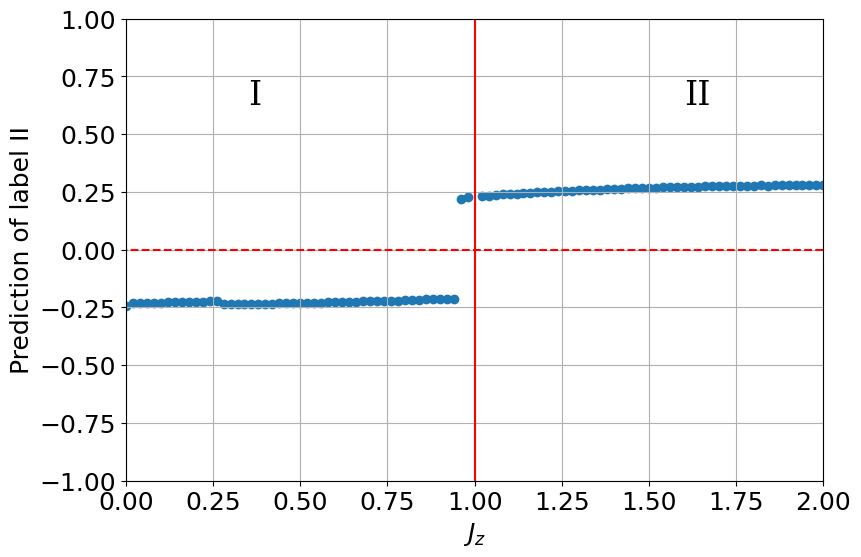

In [31]:

# %matplotlib inline
# plt.rcParams.update({'font.size': 14})
# plt.figure()
fields = np.array(df_total[n_max])
plt.scatter(fields, preds)

plt.xlabel(r'$J_z$')
plt.ylabel('Prediction of label II')
plt.grid()
plt.ylim([-1, 1])
plt.xlim([0, 2])
plt.plot([1, 1], [-1, 1], 'r')
plt.text(0.35, 0.63, 'I', fontsize=24, fontfamily='serif')
plt.text(1.6, 0.63, 'II', fontsize=24, fontfamily='serif')
plt.plot([2, 0], [0,0], 'r--')
plt.show()